# 04 - Market Data Processing

This notebook covers market data ingestion, cleaning, feature engineering, and real-time processing techniques.

Objectives:
- Parse and validate tick data from multiple sources
- Handle missing data, outliers, and timestamp alignment
- Build technical indicators and derived features
- Optimize for low-latency streaming scenarios

## Data Flow Architecture
The diagram shows how raw market data flows through processing stages.

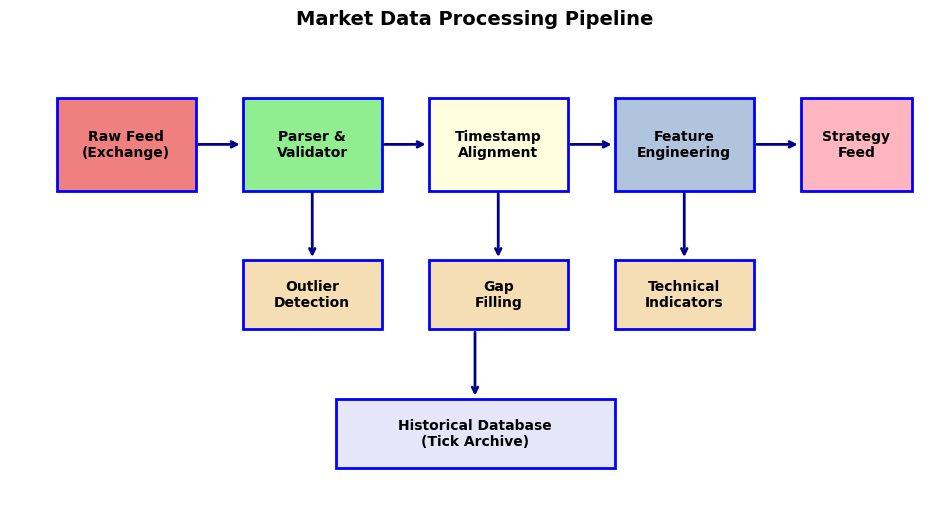

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

def draw_box(x, y, w, h, text, color='lightblue'):
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor=color)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=10, weight='bold')

def draw_arrow(x1, y1, x2, y2, text=''):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1), 
                arrowprops=dict(arrowstyle='->', lw=2, color='darkblue'))
    if text:
        mx, my = (x1+x2)/2, (y1+y2)/2
        ax.text(mx, my+0.03, text, ha='center', fontsize=8)

# Processing pipeline boxes
draw_box(0.05, 0.7, 0.15, 0.2, 'Raw Feed\n(Exchange)', 'lightcoral')
draw_box(0.25, 0.7, 0.15, 0.2, 'Parser &\nValidator', 'lightgreen')
draw_box(0.45, 0.7, 0.15, 0.2, 'Timestamp\nAlignment', 'lightyellow')
draw_box(0.65, 0.7, 0.15, 0.2, 'Feature\nEngineering', 'lightsteelblue')
draw_box(0.85, 0.7, 0.12, 0.2, 'Strategy\nFeed', 'lightpink')

# Support systems
draw_box(0.25, 0.4, 0.15, 0.15, 'Outlier\nDetection', 'wheat')
draw_box(0.45, 0.4, 0.15, 0.15, 'Gap\nFilling', 'wheat')
draw_box(0.65, 0.4, 0.15, 0.15, 'Technical\nIndicators', 'wheat')

# Storage
draw_box(0.35, 0.1, 0.3, 0.15, 'Historical Database\n(Tick Archive)', 'lavender')

# Arrows for main flow
draw_arrow(0.20, 0.8, 0.25, 0.8)
draw_arrow(0.40, 0.8, 0.45, 0.8)
draw_arrow(0.60, 0.8, 0.65, 0.8)
draw_arrow(0.80, 0.8, 0.85, 0.8)

# Arrows to support
draw_arrow(0.325, 0.7, 0.325, 0.55)
draw_arrow(0.525, 0.7, 0.525, 0.55)
draw_arrow(0.725, 0.7, 0.725, 0.55)

# Arrow to storage
draw_arrow(0.5, 0.4, 0.5, 0.25)

plt.title('Market Data Processing Pipeline', fontsize=14, weight='bold', pad=20)
plt.show()

## Basic Data Structures and Parsing
Define structures for tick data and implement basic parsing logic.

In [2]:
from dataclasses import dataclass
from typing import Optional, List, Dict
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

@dataclass
class Tick:
    timestamp: datetime
    symbol: str
    price: float
    volume: int
    side: str  # 'B' for buy, 'S' for sell
    exchange: str = 'GENERIC'
    
    def __post_init__(self):
        if self.price <= 0:
            raise ValueError(f"Invalid price: {self.price}")
        if self.volume < 0:
            raise ValueError(f"Invalid volume: {self.volume}")

class MarketDataProcessor:
    def __init__(self, symbol: str):
        self.symbol = symbol
        self.ticks: List[Tick] = []
        self.last_price = None
        self.price_history = []
        
    def add_tick(self, tick: Tick) -> bool:
        """Add tick with basic validation"""
        try:
            # Price spike detection (>5% move)
            if self.last_price and abs(tick.price - self.last_price) / self.last_price > 0.05:
                print(f"Warning: Large price move detected: {self.last_price} -> {tick.price}")
                
            self.ticks.append(tick)
            self.last_price = tick.price
            self.price_history.append(tick.price)
            return True
        except Exception as e:
            print(f"Failed to add tick: {e}")
            return False
    
    def get_ohlc(self, window_seconds: int = 60) -> Dict:
        """Generate OHLC from ticks"""
        if not self.ticks:
            return None
            
        prices = [t.price for t in self.ticks[-100:]]  # Last 100 ticks
        volumes = [t.volume for t in self.ticks[-100:]]
        
        return {
            'open': prices[0] if prices else None,
            'high': max(prices) if prices else None,
            'low': min(prices) if prices else None,
            'close': prices[-1] if prices else None,
            'volume': sum(volumes),
            'count': len(prices)
        }

# Demo with synthetic data
processor = MarketDataProcessor('AAPL')
base_time = datetime.now()

# Generate sample ticks
np.random.seed(42)
price = 150.0
for i in range(20):
    price += np.random.normal(0, 0.1)
    tick = Tick(
        timestamp=base_time + timedelta(seconds=i),
        symbol='AAPL',
        price=round(price, 2),
        volume=np.random.randint(100, 1000),
        side='B' if np.random.random() > 0.5 else 'S'
    )
    processor.add_tick(tick)

ohlc = processor.get_ohlc()
print(f"OHLC: {ohlc}")
print(f"Total ticks processed: {len(processor.ticks)}")

OHLC: {'open': 150.05, 'high': 150.17, 'low': 149.6, 'close': 150.05, 'volume': 9303, 'count': 20}
Total ticks processed: 20


## Technical Indicators Implementation
Build common technical indicators with optimized calculations.

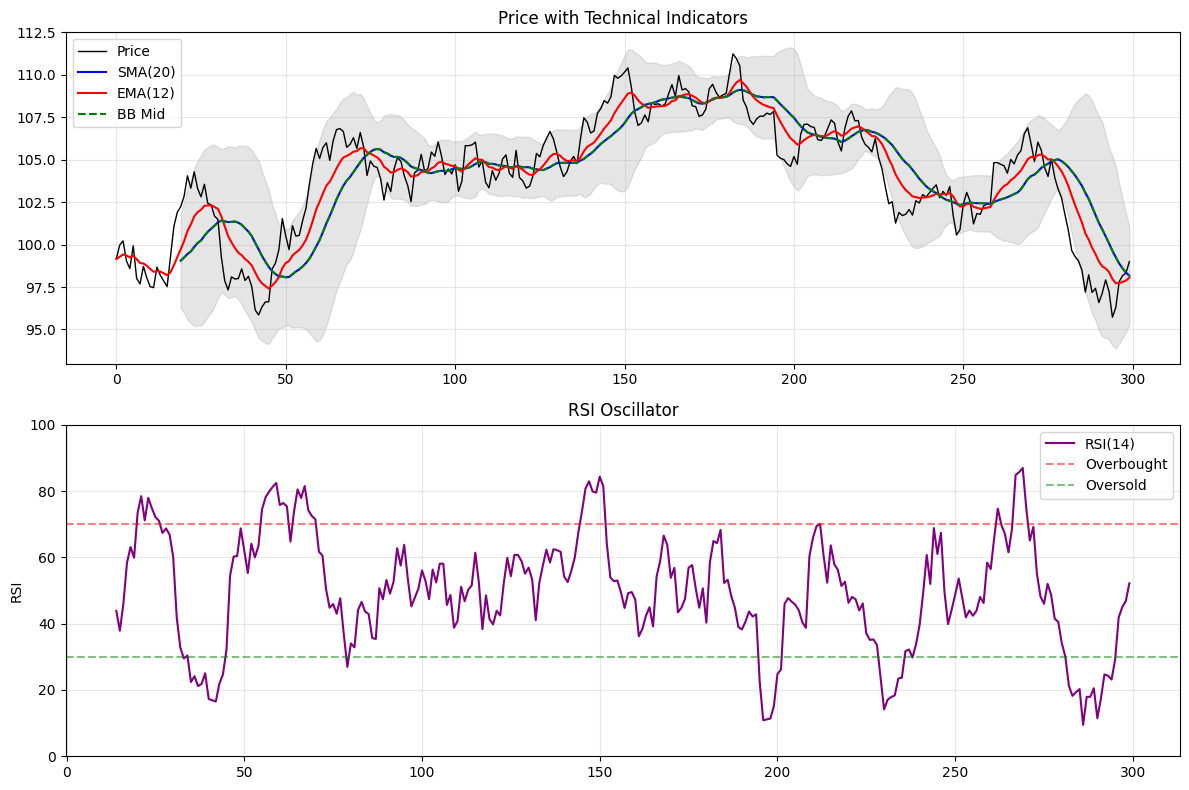

Latest RSI: 52.2
Price vs BB Upper: 99.00 vs 101.05


In [3]:
class TechnicalIndicators:
    @staticmethod
    def sma(prices: np.ndarray, window: int) -> np.ndarray:
        """Simple Moving Average"""
        return np.convolve(prices, np.ones(window)/window, mode='valid')
    
    @staticmethod
    def ema(prices: np.ndarray, alpha: float) -> np.ndarray:
        """Exponential Moving Average"""
        ema = np.zeros_like(prices)
        ema[0] = prices[0]
        for i in range(1, len(prices)):
            ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
        return ema
    
    @staticmethod
    def rsi(prices: np.ndarray, window: int = 14) -> np.ndarray:
        """Relative Strength Index"""
        deltas = np.diff(prices)
        gains = np.where(deltas > 0, deltas, 0)
        losses = np.where(deltas < 0, -deltas, 0)
        
        avg_gains = np.convolve(gains, np.ones(window)/window, mode='valid')
        avg_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
        
        rs = avg_gains / (avg_losses + 1e-10)  # Avoid division by zero
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    @staticmethod
    def bollinger_bands(prices: np.ndarray, window: int = 20, num_std: float = 2.0):
        """Bollinger Bands"""
        sma = TechnicalIndicators.sma(prices, window)
        rolling_std = np.array([np.std(prices[i:i+window]) for i in range(len(prices)-window+1)])
        
        upper_band = sma + (rolling_std * num_std)
        lower_band = sma - (rolling_std * num_std)
        
        return sma, upper_band, lower_band

# Demo with real-looking price data
np.random.seed(123)
n_points = 300
prices = 100 + np.cumsum(np.random.normal(0.02, 0.8, n_points))  # Trending with noise

# Calculate indicators
sma_20 = TechnicalIndicators.sma(prices, 20)
ema_12 = TechnicalIndicators.ema(prices, 2/(12+1))
rsi_14 = TechnicalIndicators.rsi(prices, 14)
bb_mid, bb_upper, bb_lower = TechnicalIndicators.bollinger_bands(prices, 20)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Price and moving averages
ax1.plot(prices, label='Price', color='black', linewidth=1)
ax1.plot(range(19, len(prices)), sma_20, label='SMA(20)', color='blue')
ax1.plot(ema_12, label='EMA(12)', color='red')
ax1.plot(range(19, len(prices)), bb_mid, label='BB Mid', color='green', linestyle='--')
ax1.fill_between(range(19, len(prices)), bb_lower, bb_upper, alpha=0.2, color='gray')
ax1.set_title('Price with Technical Indicators')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RSI
ax2.plot(range(14, 14 + len(rsi_14)), rsi_14, label='RSI(14)', color='purple')
ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
ax2.set_title('RSI Oscillator')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Latest RSI: {rsi_14[-1]:.1f}")
print(f"Price vs BB Upper: {prices[-1]:.2f} vs {bb_upper[-1]:.2f}")

## Interactive Parameter Tuning
Explore how indicator parameters affect signals and sensitivity.

In [4]:
try:
    import ipywidgets as widgets
    from ipywidgets import interact
    widgets_available = True
except ImportError:
    widgets_available = False
    print("ipywidgets not available, using static plots")

# Generate sample price series
np.random.seed(456)
t = np.linspace(0, 4*np.pi, 200)
trend = 0.1 * t
cycle = 5 * np.sin(0.5 * t)
noise = np.random.normal(0, 1, len(t))
prices = 100 + trend + cycle + noise

def plot_indicators(sma_window=20, ema_span=12, rsi_window=14, bb_std=2.0):
    """Interactive plotting function"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Calculate indicators with current parameters
    sma = TechnicalIndicators.sma(prices, sma_window)
    ema = TechnicalIndicators.ema(prices, 2/(ema_span+1))
    rsi = TechnicalIndicators.rsi(prices, rsi_window)
    bb_mid, bb_up, bb_low = TechnicalIndicators.bollinger_bands(prices, sma_window, bb_std)
    
    # Price plot
    ax1.plot(prices, 'k-', label='Price', linewidth=1.5)
    ax1.plot(range(sma_window-1, len(prices)), sma, 'b-', label=f'SMA({sma_window})')
    ax1.plot(ema, 'r-', label=f'EMA({ema_span})')
    ax1.plot(range(sma_window-1, len(prices)), bb_mid, 'g--', label='BB Mid')
    ax1.fill_between(range(sma_window-1, len(prices)), bb_low, bb_up, 
                     alpha=0.2, color='gray', label=f'BB(±{bb_std}σ)')
    ax1.set_title('Price and Moving Averages')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # RSI plot
    if len(rsi) > 0:
        ax2.plot(range(rsi_window, len(prices)), rsi, 'purple', linewidth=2)
        ax2.axhline(70, color='red', linestyle='--', alpha=0.7)
        ax2.axhline(30, color='green', linestyle='--', alpha=0.7)
        ax2.fill_between(range(rsi_window, len(prices)), 70, 100, alpha=0.1, color='red')
        ax2.fill_between(range(rsi_window, len(prices)), 0, 30, alpha=0.1, color='green')
    ax2.set_title(f'RSI({rsi_window})')
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('RSI Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if widgets_available:
    interact(plot_indicators, 
             sma_window=(5, 50, 5),
             ema_span=(5, 30, 1), 
             rsi_window=(5, 30, 1),
             bb_std=(1.0, 3.0, 0.1))
else:
    # Static version
    plot_indicators()

interactive(children=(IntSlider(value=20, description='sma_window', max=50, min=5, step=5), IntSlider(value=12…

## Data Quality and Outlier Detection
Implement robust methods for detecting and handling data anomalies.

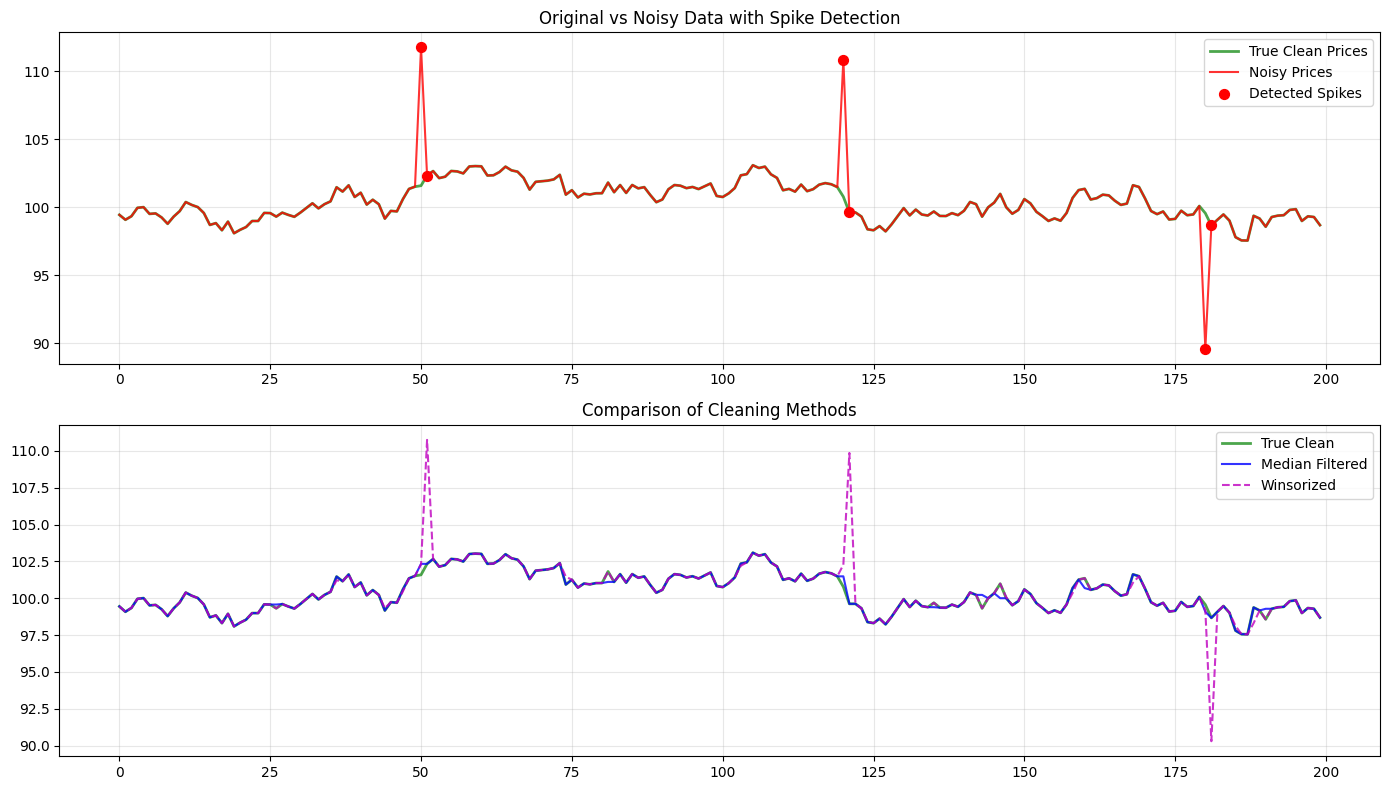

Detected 6 price spikes
  Spike 1: Index 50, Price 111.75, Change 10.1%
  Spike 2: Index 51, Price 102.33, Change 8.4%
  Spike 3: Index 120, Price 110.86, Change 9.2%


In [5]:
class DataQualityChecker:
    def __init__(self, price_change_threshold=0.05, volume_z_threshold=3.0):
        self.price_threshold = price_change_threshold
        self.volume_threshold = volume_z_threshold
        self.price_history = []
        self.volume_history = []
    
    def check_price_spike(self, current_price: float) -> dict:
        """Detect abnormal price movements"""
        if not self.price_history:
            self.price_history.append(current_price)
            return {'is_spike': False, 'change_pct': 0}
        
        last_price = self.price_history[-1]
        change_pct = abs(current_price - last_price) / last_price
        is_spike = change_pct > self.price_threshold
        
        self.price_history.append(current_price)
        if len(self.price_history) > 100:  # Keep only recent history
            self.price_history.pop(0)
            
        return {
            'is_spike': is_spike,
            'change_pct': change_pct,
            'direction': 'up' if current_price > last_price else 'down'
        }
    
    def check_volume_anomaly(self, current_volume: int) -> dict:
        """Detect unusual volume using z-score"""
        self.volume_history.append(current_volume)
        
        if len(self.volume_history) < 10:
            return {'is_anomaly': False, 'z_score': 0}
        
        recent_volumes = self.volume_history[-50:]  # Last 50 observations
        mean_vol = np.mean(recent_volumes[:-1])  # Exclude current
        std_vol = np.std(recent_volumes[:-1])
        
        if std_vol == 0:
            z_score = 0
        else:
            z_score = (current_volume - mean_vol) / std_vol
            
        if len(self.volume_history) > 100:
            self.volume_history.pop(0)
            
        return {
            'is_anomaly': abs(z_score) > self.volume_threshold,
            'z_score': z_score,
            'volume_type': 'high' if z_score > 0 else 'low'
        }
    
    def clean_price_series(self, prices: np.ndarray, method='median_filter') -> np.ndarray:
        """Clean price series by removing/smoothing outliers"""
        if method == 'median_filter':
            # Simple median filter for spike removal
            cleaned = prices.copy()
            for i in range(2, len(prices)-2):
                window = prices[i-2:i+3]
                if abs(prices[i] - np.median(window)) > 2 * np.std(window):
                    cleaned[i] = np.median(window)
            return cleaned
        
        elif method == 'winsorize':
            # Cap extreme values at 5th/95th percentiles
            returns = np.diff(prices) / prices[:-1]
            lower, upper = np.percentile(returns, [5, 95])
            
            cleaned = prices.copy()
            for i in range(1, len(prices)):
                ret = (prices[i] - prices[i-1]) / prices[i-1]
                if ret < lower:
                    cleaned[i] = prices[i-1] * (1 + lower)
                elif ret > upper:
                    cleaned[i] = prices[i-1] * (1 + upper)
            return cleaned
        
        return prices

# Demo with noisy data
np.random.seed(789)
clean_prices = 100 + np.cumsum(np.random.normal(0, 0.5, 200))

# Add some artificial spikes and anomalies
noisy_prices = clean_prices.copy()
spike_indices = [50, 120, 180]
for idx in spike_indices:
    noisy_prices[idx] *= (1 + 0.1 * np.random.choice([-1, 1]))  # ±10% spikes

# Initialize quality checker and process data
checker = DataQualityChecker(price_change_threshold=0.03)
anomalies = []

for i, price in enumerate(noisy_prices):
    spike_info = checker.check_price_spike(price)
    if spike_info['is_spike']:
        anomalies.append((i, price, spike_info['change_pct']))

# Clean the data
cleaned_median = checker.clean_price_series(noisy_prices, 'median_filter')
cleaned_winsor = checker.clean_price_series(noisy_prices, 'winsorize')

# Plot comparison
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(clean_prices, 'g-', label='True Clean Prices', alpha=0.7, linewidth=2)
plt.plot(noisy_prices, 'r-', label='Noisy Prices', alpha=0.8)
if anomalies:
    anomaly_x, anomaly_y, _ = zip(*anomalies)
    plt.scatter(anomaly_x, anomaly_y, color='red', s=50, zorder=5, label='Detected Spikes')
plt.title('Original vs Noisy Data with Spike Detection')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(clean_prices, 'g-', label='True Clean', alpha=0.7, linewidth=2)
plt.plot(cleaned_median, 'b-', label='Median Filtered', alpha=0.8)
plt.plot(cleaned_winsor, 'm--', label='Winsorized', alpha=0.8)
plt.title('Comparison of Cleaning Methods')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Detected {len(anomalies)} price spikes")
for i, (idx, price, change) in enumerate(anomalies[:3]):  # Show first 3
    print(f"  Spike {i+1}: Index {idx}, Price {price:.2f}, Change {change:.1%}")

## Exercises
1. Implement a VWAP (Volume Weighted Average Price) calculator
2. Build a real-time correlation tracker between two price series
3. Create a gaps detector that identifies missing timestamps in tick data

Solutions are toggleable below.

In [6]:
show_solutions = False

try:
    import ipywidgets as widgets
    toggle = widgets.ToggleButton(value=False, description='Show Solutions')
    display(toggle)
    
    def on_toggle_change(change):
        global show_solutions
        show_solutions = change['new']
        
    toggle.observe(on_toggle_change, names='value')
except ImportError:
    pass

if show_solutions:
    print("SOLUTION 1: VWAP Calculator")
    
    class VWAPCalculator:
        def __init__(self):
            self.price_volume_sum = 0.0
            self.volume_sum = 0
            
        def add_trade(self, price: float, volume: int):
            self.price_volume_sum += price * volume
            self.volume_sum += volume
            
        def get_vwap(self) -> float:
            return self.price_volume_sum / self.volume_sum if self.volume_sum > 0 else 0
        
        def reset(self):
            self.price_volume_sum = 0.0
            self.volume_sum = 0
    
    print("\nSOLUTION 2: Real-time Correlation Tracker")
    
    class CorrelationTracker:
        def __init__(self, window_size=100):
            self.window_size = window_size
            self.x_values = []
            self.y_values = []
            
        def add_pair(self, x: float, y: float):
            self.x_values.append(x)
            self.y_values.append(y)
            
            if len(self.x_values) > self.window_size:
                self.x_values.pop(0)
                self.y_values.pop(0)
                
        def get_correlation(self) -> float:
            if len(self.x_values) < 2:
                return 0
            return np.corrcoef(self.x_values, self.y_values)[0, 1]
    
    print("\nSOLUTION 3: Gaps Detector")
    
    class GapsDetector:
        def __init__(self, expected_interval_ms=1000):
            self.expected_interval = expected_interval_ms
            self.last_timestamp = None
            self.gaps = []
            
        def check_timestamp(self, timestamp: datetime) -> dict:
            if self.last_timestamp is None:
                self.last_timestamp = timestamp
                return {'has_gap': False}
                
            delta_ms = (timestamp - self.last_timestamp).total_seconds() * 1000
            expected_ms = self.expected_interval
            
            if delta_ms > expected_ms * 1.5:  # 50% tolerance
                gap_info = {
                    'has_gap': True,
                    'gap_duration_ms': delta_ms,
                    'expected_ms': expected_ms,
                    'start_time': self.last_timestamp,
                    'end_time': timestamp
                }
                self.gaps.append(gap_info)
                self.last_timestamp = timestamp
                return gap_info
            
            self.last_timestamp = timestamp
            return {'has_gap': False}
    
    # Demo the solutions
    vwap = VWAPCalculator()
    vwap.add_trade(100.5, 200)
    vwap.add_trade(100.7, 150)
    vwap.add_trade(100.3, 300)
    print(f"\nVWAP: ${vwap.get_vwap():.2f}")
    
    corr = CorrelationTracker(50)
    x_series = np.random.randn(30)
    y_series = 0.7 * x_series + 0.3 * np.random.randn(30)  # Correlated series
    for x, y in zip(x_series, y_series):
        corr.add_pair(x, y)
    print(f"Correlation: {corr.get_correlation():.3f}")
    
    print("\nSolutions loaded successfully!")
else:
    print("Toggle the button above to reveal exercise solutions")

ToggleButton(value=False, description='Show Solutions')

Toggle the button above to reveal exercise solutions


## Performance Benchmarks
Compare different approaches for high-frequency data processing.

In [7]:
import time
from collections import deque

# Generate large dataset for benchmarking
n_samples = 100000
np.random.seed(999)
large_prices = 100 + np.cumsum(np.random.normal(0, 0.1, n_samples))

def benchmark_moving_average_methods(prices, window=20):
    """Compare different moving average implementations"""
    
    # Method 1: Naive Python loop
    start = time.time()
    ma_naive = []
    for i in range(window-1, len(prices)):
        ma_naive.append(sum(prices[i-window+1:i+1]) / window)
    time_naive = time.time() - start
    
    # Method 2: NumPy convolve
    start = time.time()
    ma_numpy = np.convolve(prices, np.ones(window)/window, mode='valid')
    time_numpy = time.time() - start
    
    # Method 3: Pandas rolling (if available)
    try:
        import pandas as pd
        start = time.time()
        ma_pandas = pd.Series(prices).rolling(window).mean().dropna().values
        time_pandas = time.time() - start
        pandas_available = True
    except ImportError:
        time_pandas = float('inf')
        pandas_available = False
    
    # Method 4: Streaming with deque
    start = time.time()
    ma_stream = []
    buffer = deque(maxlen=window)
    for price in prices:
        buffer.append(price)
        if len(buffer) == window:
            ma_stream.append(sum(buffer) / window)
    time_stream = time.time() - start
    
    return {
        'naive': time_naive,
        'numpy': time_numpy, 
        'pandas': time_pandas if pandas_available else None,
        'streaming': time_stream
    }

# Run benchmarks
print(f"Benchmarking with {len(large_prices):,} price points...\n")

times = benchmark_moving_average_methods(large_prices)

print("Moving Average Performance (20-period):")
print("-" * 40)
for method, time_taken in times.items():
    if time_taken is not None:
        print(f"{method.capitalize():12s}: {time_taken:.4f} seconds")
        
# Find fastest method
valid_times = {k: v for k, v in times.items() if v is not None}
fastest = min(valid_times.items(), key=lambda x: x[1])
print(f"\nFastest method: {fastest[0]} ({fastest[1]:.4f}s)")

# Memory usage comparison for streaming vs batch
print("\n" + "="*50)
print("MEMORY EFFICIENCY COMPARISON")
print("="*50)

batch_memory = n_samples * 8  # 8 bytes per float64
stream_memory = 20 * 8  # Only window size needed

print(f"Batch processing memory: {batch_memory:,} bytes ({batch_memory/1024/1024:.1f} MB)")
print(f"Streaming memory:        {stream_memory:,} bytes ({stream_memory/1024:.1f} KB)")
print(f"Memory reduction:        {batch_memory/stream_memory:.0f}x smaller")

Benchmarking with 100,000 price points...



Moving Average Performance (20-period):
----------------------------------------
Naive       : 0.1613 seconds
Numpy       : 0.0024 seconds
Pandas      : 0.0058 seconds
Streaming   : 0.0677 seconds

Fastest method: numpy (0.0024s)

MEMORY EFFICIENCY COMPARISON
Batch processing memory: 800,000 bytes (0.8 MB)
Streaming memory:        160 bytes (0.2 KB)
Memory reduction:        5000x smaller


## Real-world Applications

**Market Data Processing in Production Systems:**

1. **High-Frequency Trading Firms**: Process millions of ticks per second with microsecond latency requirements

2. **Risk Management Systems**: Real-time monitoring of portfolio exposure using live market data feeds

3. **Regulatory Reporting**: Clean and validate trade data for MiFID II/Dodd-Frank compliance

4. **Market Making Algorithms**: Maintain accurate bid-ask spreads using cleaned, low-latency price feeds

5. **Quantitative Research**: Historical data cleaning and feature engineering for strategy backtesting

**Key Considerations:**
- **Latency**: Sub-millisecond processing for HFT applications
- **Throughput**: Handle peak market hours (millions of messages/second)
- **Data Quality**: Robust outlier detection prevents erroneous trading decisions
- **Scalability**: Horizontal scaling across multiple instruments and exchanges